In [11]:
import numpy as np
import matplotlib.pyplot as plt
import starry

import exoplanet as exo


In [12]:
starry.__version__

'1.0.0.dev3'

In [13]:
map = starry.Map(ydeg=20, udeg=2, rv=True, lazy=False)


In [25]:
time, vels, verr = np.loadtxt('../data/transit.vels', usecols=[0,1,2], unpack=True)
time -= 2458706.5

In [22]:
Prot = 2.85             # days
P = 8.1387              # days
t0 = 0.165
e = 0.0                   
w = 0.0
inc = 82.0


vsini = 18.3 * 1e3      # m /s
r = 0.05972             # In units of Rstar
b = -0.40               # I want it to transit in the South!
a = 19.42               # In units of Rstar
u1 = 0.95
u2 = 0.20
obl = 10
gamma = -6
gammadot = 100

veq = vsini / np.sin(inc * np.pi / 180.0)



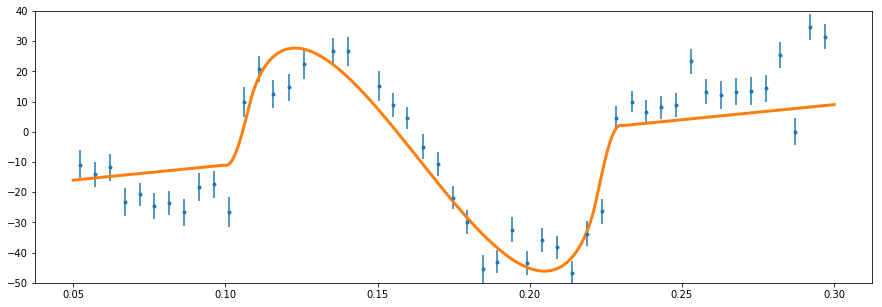

In [26]:
map.reset()
map.inc = inc
map.obl = obl
#map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
map[1:] = [u1, u2]
map.veq = veq

orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=b, ecc=e, omega=w, r_star=1.0) 


t = np.linspace(0.05, 0.30, 1000)
x, y, z = orbit.get_relative_position(t)
xo = x.eval()
yo = y.eval()
zo = z.eval()
theta = 360.0 / Prot * t

rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
rv += gamma + gammadot*(t-0.15)

plt.figure(figsize=(15,5))
plt.plot(t, rv, "C1", lw=3)
plt.errorbar(time, vels, yerr=verr, fmt='.')
plt.ylim(-50, 40);

Compiling `render`... Done.


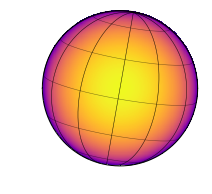

In [17]:
map.show(rv=False)

In [28]:
from scipy.optimize import minimize

In [121]:
tuse = time + 0.0
euse = verr + 0.0
vuse = vels + 0.0

map.reset()

def rmcurve(params):

    vsini, r, b, a, u1, u2, obl, gamma, gammadot, jitter_good, jitter_bad, q = params
    veq = vsini / np.sin(inc * np.pi / 180.0)

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq

    orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=b, ecc=e, omega=w, r_star=1.0) 

    x, y, z = orbit.get_relative_position(tuse)

    xo = x.eval()
    yo = y.eval()
    zo = z.eval()
    theta = 360.0 / Prot * tuse

    rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    rv += gamma + gammadot*(tuse-0.15)
    
    
    var_good = (euse**2 + jitter_good**2)
    var_bad  = (euse**2 + jitter_bad**2)
    gooddata = -0.5*q*(np.sum((rv-vuse)**2/var_good + np.log(2*np.pi*var_good)))
    baddata  = -0.5*(1-q)*(np.sum((rv-vuse)**2/var_bad + np.log(2*np.pi*var_bad)))
    lnprob = gooddata + baddata

    print(-1*lnprob)
    return -1*lnprob



In [91]:
def plot_rmcurve(params):

    vsini, r, b, a, u1, u2, obl, gamma, gammadot, jitter_good, jitter_bad, q = params
    veq = vsini / np.sin(inc * np.pi / 180.0)

    map.reset()
    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq
    
    orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=b, ecc=e, omega=w, r_star=1.0) 


    t = np.linspace(0.05, 0.30, 1000)
    x, y, z = orbit.get_relative_position(t)
    xo = x.eval()
    yo = y.eval()
    zo = z.eval()
    theta = 360.0 / Prot * t

    rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    rv += gamma + gammadot*(t-0.15)

    plt.figure(figsize=(15,5))
    plt.plot(t, rv, "C1", lw=3)
    plt.errorbar(time, vels, yerr=verr, fmt='.')
    plt.ylim(-50, 40);
    plt.show()


In [122]:
inputs = np.array([18300, 0.0588, -0.09, 20.79, 1.0, 0.00, 13.15, -9.3, 200.1, 1.0, 10.0, 0.8])

bnds = ((12000, 24000), (0.04, 0.07), (-1.0, 0.0), (15,25), (0,1),(0,1), (0,90), (-20,20),(50,300), (0.0, 2.0), (2.0, 20.0), (0.0, 1.0))
rmcurve(inputs)

186.86336301250347


/home/bmontet/anaconda3/envs/p35/lib/python3.5/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


186.86336301250347

In [123]:
res = minimize(rmcurve, inputs, method='L-BFGS-B', bounds=bnds)

186.86336301250347
186.86336301252842
186.86337915990748
186.86336308308444
186.86336299646518
186.86336297251762
186.86336306296502
186.86336301089574
186.86336298322408
186.86336301235033
186.86336297484274
186.86336301666276
186.86336316945534
284.7714650259291
284.77146502592905
284.77146484657817
284.7714648726324
284.77146502613084
284.77146503685697
284.7714650358456
284.7714650259195
284.7714650444388
284.7714650288602
284.7714650259291
284.7714648506526
284.77146975107195
185.35956504722256
185.35956504722435
185.35956682866168
185.35956484717647
185.35956508901344
185.35956514358696
185.35956518775572
185.35956504793532
185.35956501860431
185.35956504766455
185.35956501055776
185.35956505218311
185.35956519494235
185.34364023526152
185.3436402352612
185.3436406783013
185.3436400394346
185.3436402759933
185.34364032479078
185.34364036941457
185.34364023602257
185.3436402070654
185.34364023574258
185.34364019861493
185.3436402401949
185.3436403825949
185.34132135449877
185.3413

172.84392718367815
172.84392720405418
172.84392732203935
172.75006590311855
172.75006590311415
172.7500632586426
172.75006585208533
172.75006590703762
172.75006590341923
172.75006591484967
172.75006590352785
172.75006589856616
172.75006590338378
172.75006590311855
172.75006592312505
172.75006604738746
172.5146908976344
172.5146908976276
172.514686641443
172.51469082099038
172.5146909040521
172.51469090196872
172.51469091139774
172.514690898202
172.51469089324823
172.5146908979707
172.5146908976344
172.51469091670037
172.51469105441976
171.9625626769536
171.96256267694307
171.96255597502005
171.96256256061184
171.962562687642
171.9625626884121
171.96256269528197
171.9625626776982
171.96256267320246
171.96256267742032
171.9625626769536
171.96256269363232
171.9625628555266
170.8441694845356
170.84416948452034
170.84415967240628
170.84416932052895
170.84416950190916
170.84416950695842
170.84416951214214
170.84416948535193
170.84416948268685
170.84416948522895
170.8441694845356
170.84416949

KeyboardInterrupt: 

In [94]:
# vsini, r, b, a, u1, u2, obl, gamma, gammadot = params
print(res.x.tolist())

[18300.012920585246, 0.058325908653385085, -0.17989438892573809, 20.56513997921657, 1.0, 0.0, 17.311534969903935, -6.657428484257285, 185.09863367853995, 1.2029170041130754, 5.885716645051851, 0.0]


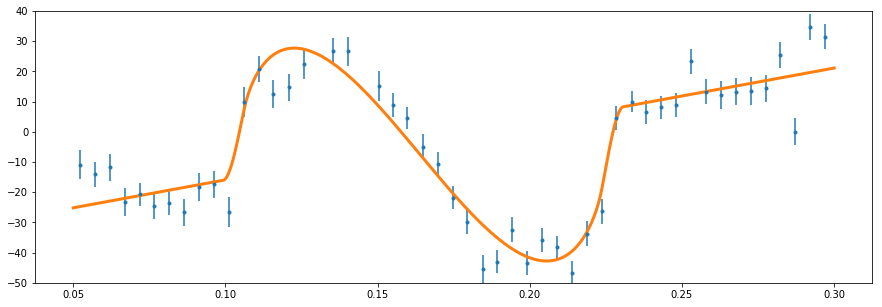

In [92]:
test = res.x + 0.0
#test[0] = 20000
#test[6] = 0.0
#test[7] = -10
plot_rmcurve(test)

In [95]:
import pymc3 as pm
import theano.tensor as tt

In [125]:
with pm.Model() as model:
    trend = pm.Normal("Trend", mu=50, sd=100)
    obl   = pm.Uniform('Obl', lower=0, upper=90)
    
    map.reset()
    print(map)
    #map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    #map[1:] = [u1, u2]
    #map.veq = veq

    orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=b, ecc=e, omega=w, r_star=1.0) 

    x, y, z = orbit.get_relative_position(tuse)

    xo = x.eval()
    yo = y.eval()
    zo = z.eval()
    theta = 360.0 / Prot * tuse

    rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    rv += gamma + trend*(tuse-0.15)
    
    rv_model = pm.Deterministic('rv_model', rv)
    

<starry.Map.Map.Map.<locals>.Map object at 0x7fa9f2e14898>


ValueError: setting an array element with a sequence.

In [103]:
with model:
    pm.Normal("obs", mu=rv_model, sd = euse, observed=vuse)
    
    map_soln = exo.optimize(start=model.test_point, vars=[trend])

optimizing logp for variables: ['Trend']
message: Optimization terminated successfully.
logp: -982.8502285454886 -> -598.717706870738


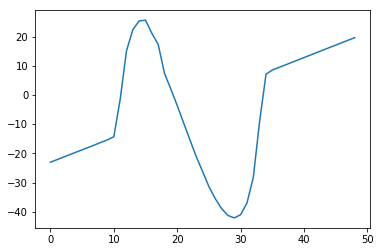

In [106]:
plt.plot(map_soln['rv_model'])

In [112]:
orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=b, ecc=e, omega=w, r_star=1.0) 

x, y, z = orbit.get_relative_position(tuse)
rv = orbit.get_radial_velocity(tuse)